# VGG16 CNN 모델의 평가 결과 클래스 활성 히트맵(CAM) 시각화하기
## 1. VGG16을 활용한 이미지 다중 클래스 분류
- 다중 클래스 분류 이미지 분석 모델이 이미지를 분석할 때 어떤 부분에서 이미지가 해당 클래스의 결정에 기여하는지 표시하는 기법을 구현할 것인데, 구체적인 구현은 "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization."(Ramprasaath R. Selvaraju et al., arXiv (2017))에 기술되어 있는 것을 따랐다.
- 입력 이미지가 주어지면 입력 이미지가 각 채널을 활성화하는 정도에 대한 공간적인 맵을 클래스에 대한 각 채널의 중요도로 가중치를 부여하여 입력 이미지가 클래스를 활성화하는 정도에 대한 공간적인 맵을 만든다.

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K
import numpy as np
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
model = VGG16(weights='imagenet')


In [3]:

img_path = '../datasets/creative_commons_elephant.jpg'

img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

- 기존 프로젝트들과 다르게 VGG16 모델의 입력 형식을 그대로 유지하고 최상위 분류기 역시 포함하여 사용했기 때문에 이에 맞춰서 입력 이미지의 사이즈를 수정해준다.

In [4]:
preds = model.predict(x)
print("Predicted:", decode_predictions(preds, top=3)[0])

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Predicted: [('n02504458', 'African_elephant', 0.8268862), ('n01871265', 'tusker', 0.16276982), ('n02504013', 'Indian_elephant', 0.010191001)]


In [5]:
np.argmax(preds[0])

386

## 2. Grad-CAM 히트맵 생성
- 모델이 이미지를 분석한 결과 다양한 클래스에 대한 예측이 나왔는데, 가장 높은 확률은 약 82.6%로 아프리카 코끼리(386번 인덱스)가 포함되어 있다고 추측했다.
- 이 클래스를 활성화한 부위를 시각화하기 위해 Grad-CAM 과정을 구현한다.

In [6]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2,))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

- 아프리카 코끼리 클래스에 대한 출력에 대한 최상위 합성곱 층의 출력(필터에 대한 활성화 정도)의 그래디언트를 구한다. 그리고 합성곱 층의 활성화 정도에 그래디언트를 곱하여, 코끼리 클래스의 활성화에 기여하는 부분에 대한 공간 맵을 구성한다.

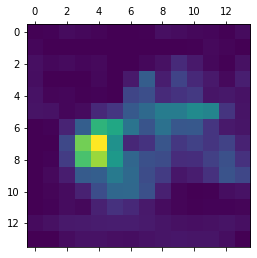

In [7]:
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

- 출력된 히트맵의 색상 패턴을 변경하고 OpenCV를 활용해 원본 이미지 위에 합성하여 이미지의 어떤 부분이 클래스 선정에 가장 많이 기여했는지 확인한다.

In [8]:
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
super_img_path = '../datasets/elephant_cam.jpg'
cv2.imwrite(super_img_path, superimposed_img)


True

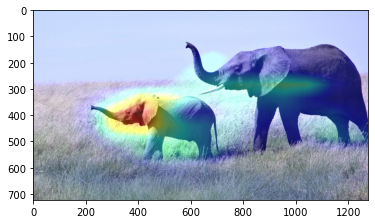

In [9]:
super_img = image.load_img(super_img_path)
plt.imshow(super_img)

- 새끼 코끼리가 있는 부분이 결과적으로 아프리카 코끼리 클래스를 선택하는데 가장 큰 기여를 했다는 것을 확인할 수 있었다.